<h1>  Build agentic AI application using Langgraph </h1>
<p> Built by Jakob Lindstrøm, aka DataJakob@Github,  for Lumos  SDC. </p>
<p> In this notebook  we will create a agentic chatbot that is especially good at Q&A for finance and portfolio generation </p> 

<h3> 1 Import libraries </h3>

In [17]:
# Enviroment 
import os

# "Lang" packages
import langchain
import langgraph
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages

# Other

# .env variables
my_api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
from pydantic import BaseModel, Field

In [84]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    stocks: Annotated[list, add_messages]
    optimal_portfolio: str

class Mission(BaseModel):
    mission: str = Field(description="""
                         Answer with one word based on the user query:
                         - "append", if the user wants to append  the stock into the portfolio.
                         - "more_info"  if the user wants more info about a stock or something else.
                         - "analyze"  if  the user wants to analyze the current portfolio
                        """)

In [31]:
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
    api_key=my_api_key
)

In [85]:
llm.invoke("hei")

AIMessage(content='Hei! Hvordan kan jeg hjelpe deg i dag?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 8, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-3ab2e910-feae-4697-af9b-75a42ff1e7a6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 11, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [49]:
from langgraph.graph import StateGraph, START, END

In [94]:
def navigator(state):
    nav_model =  llm.with_structured_output(Mission)
    response = nav_model.invoke(state["messages"]).content
    state["mission"] = response

def info():
    1
    # Normal chain where I prompt the model to answer queries about the stock
    
def stock_appender():
    1
    # Filter latest message and append the stock to the portfolio

def portfolio_analyzer():
    1
    # Intiate the analysis

def final_response():
    1
    # Generate a final response based on which node was  previously visited

In [95]:
def decision(state):

    if state["mission"] == "append":
        return "add_stock"
    elif state["mission"] == "analyze":
        return  "analyze_portfolio"
    else:
        return "more_info"

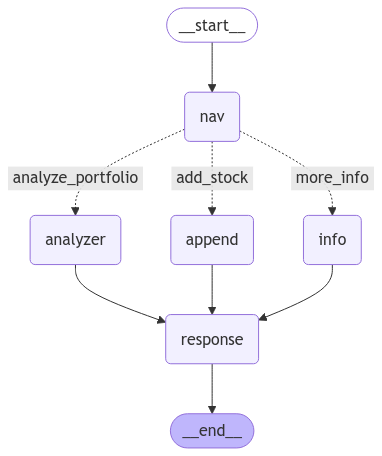

In [96]:
workflow = StateGraph(State)
# Nodes for something.
workflow.add_node("nav", navigator)
workflow.add_node("info", info)
workflow.add_node("append", stock_appender)
workflow.add_node("analyzer", portfolio_analyzer)
workflow.add_node("response", final_response)

workflow.add_edge(START, "nav")     # Non-optional move
workflow.add_conditional_edges("nav",   # Starting node
                               decision,    # Decider for which node to go to
                               # Options
                               {"more_info":"info",
                                "add_stock":"append",
                                "analyze_portfolio":"analyzer"}

)
# Non-optional moves
workflow.add_edge("info", "response")
workflow.add_edge("append", "response")
workflow.add_edge("analyzer", "response")
workflow.add_edge("response", END)

workflow.compile()